In [1]:
import os
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-11-13 16:52:31.436930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 16:52:31.445643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 16:52:31.448465: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
model = ['nl']
label = ['NL']
x_names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1', '', 'trans2', '']
for k in range(len(model)):
    if model[k] == 'mp' or model[k] == 'np':
        x_names[4], x_names[6], x_names[8] = 'exp1', 'exp2', 'exp3'
    else:
        x_names[4], x_names[6], x_names[8] = 'csq1', 'csq2', 'csq3'
y_names = [f"R_{i}" for i in range(100)]

# Define file directory and load data
dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']

# Prepare X, Y, Z based on loaded data
x_ncols, y_ncols = len(x_names), len(y_names)
nrows, data = mchain['nlines'][0], mchain['data']
X, Y = np.zeros((x_ncols, nrows)), np.zeros((y_ncols, nrows))

for i in range(x_ncols):
    X[i] = data[x_names[i]]
for i in range(y_ncols):
    Y[i] = data[y_names[i]]
Z = np.array(data['R_max']).reshape(-1, 1)  # Shape Z as (nrows, 1)

# Transpose X and Y to shape (nrows, ncols)
X, Y = X.T, Y.T

# Initialize scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))  # Shared scaler for Y and Z

# Fit-transform X
x = scaler_X.fit_transform(X)

# Mask and scale non-zero values in Y
nz = Y != 0
y = np.copy(Y)  # Copy Y to keep zeros intact
y[nz] = scaler_Y.fit_transform(Y[nz].reshape(-1, 1)).flatten() 

# Scale Z with the same scaler as Y
z = scaler_Y.transform(Z)

# Split the data for training and validation as required
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

In [3]:
tuner_dir = 'trials1'

if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Memory growth enabled for the first GPU.")
    except RuntimeError as e:
        print(f"Could not enable memory growth: {e}")
else:
    print("No GPUs found.")

Memory growth enabled for the first GPU.


I0000 00:00:1731534752.843182 3914372 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731534752.865428 3914372 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731534752.867186 3914372 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [4]:
def build_model(hp):

    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(9,)))
    
    for i in range(hp.Int('num_layers', 3, 4)):
        units = hp.Choice(f'units_{i}', [64, 128, 256, 512])
        model.add(layers.Dense(units=units, activation='relu'))
    
    model.add(layers.Dense(units=100, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mse']
    )
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='trials1',
)

tuner.search_space_summary()

I0000 00:00:1731534752.880380 3914372 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731534752.881882 3914372 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731534752.883280 3914372 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731534753.002880 3914372 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512], 'ordered': True}
units_1 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512], 'ordered': True}
units_2 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512], 'ordered': True}


In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=10
)

tuner.search(
    x_tr, y_tr,
    validation_data=(x_ts, y_ts),
    epochs=200,
    batch_size=128,
    callbacks=[early_stop]
)

Trial 50 Complete [00h 00m 19s]
val_loss: 5.082277493784204e-05

Best val_loss So Far: 3.944893614971079e-05
Total elapsed time: 00h 17m 03s


In [6]:
tuner.results_summary(num_trials=10)

Results summary
Results in trials1/untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 36 summary
Hyperparameters:
num_layers: 3
units_0: 512
units_1: 256
units_2: 512
units_3: 128
Score: 3.944893614971079e-05

Trial 12 summary
Hyperparameters:
num_layers: 4
units_0: 256
units_1: 512
units_2: 128
units_3: 512
Score: 4.421262929099612e-05

Trial 03 summary
Hyperparameters:
num_layers: 3
units_0: 64
units_1: 512
units_2: 512
units_3: 256
Score: 4.5201282773632556e-05

Trial 30 summary
Hyperparameters:
num_layers: 3
units_0: 256
units_1: 128
units_2: 512
units_3: 256
Score: 4.5943543227622285e-05

Trial 48 summary
Hyperparameters:
num_layers: 4
units_0: 256
units_1: 128
units_2: 256
units_3: 512
Score: 4.666020322474651e-05

Trial 15 summary
Hyperparameters:
num_layers: 4
units_0: 256
units_1: 128
units_2: 128
units_3: 512
Score: 4.808744415640831e-05

Trial 23 summary
Hyperparameters:
num_layers: 3
units_0: 256
units_1: 512
units_2: 256
units_3: 512

In [7]:
# Retrieve the best model and evaluate
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,332 (1.22 MB)

 Trainable params: 319,332 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1.0e-6, 
    patience=10
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6
)

# Optionally, retrain on the full dataset with optimal hyperparameters
training = best_model.fit(x_tr, y_tr, epochs=1000, validation_data=(x_ts, y_ts), \
                          batch_size=128, callbacks=[early_stop, lr_schedule])

Epoch 1/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0026 - val_mse: 0.0026 - learning_rate: 0.0010
Epoch 2/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0017 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 3/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0012 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 4/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 7.6471e-04 - val_mse: 7.6471e-04 - learning_rate: 0.0010
Epoch 5/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 7.0507e-04 - mse: 7.0507e-04 - val_loss: 6.0351e-04 - val_mse: 6.0351e-04 - learning_rate: 0.0010
Epoch 6/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7378e-04 - mse: 5.7378e-04 - val_loss: 5.1932e-04 - val_mse: 5.1932e-04 - learning_rate: 0.0010
Epoch 7/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8754e-04 - mse: 4.8754e-04 - val_loss: 4.53

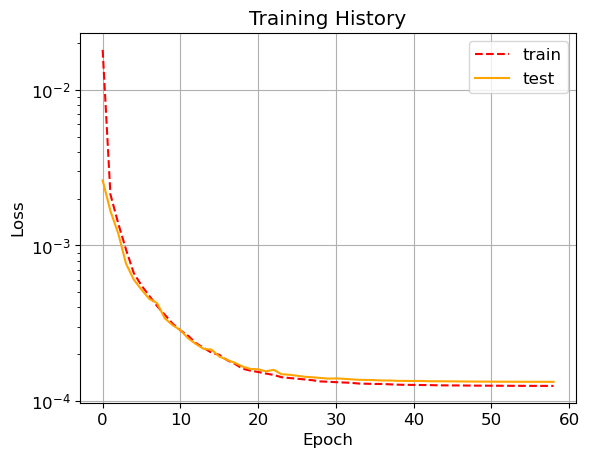

In [9]:
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


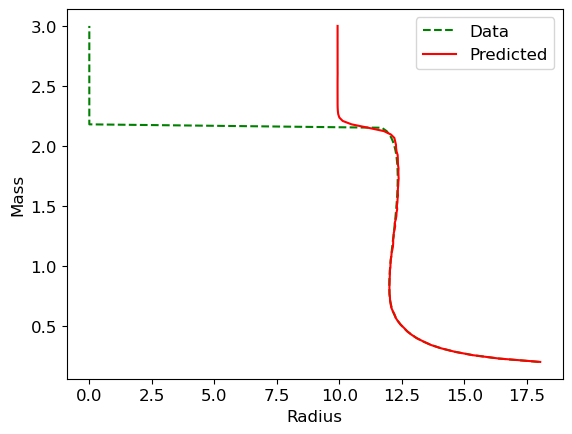

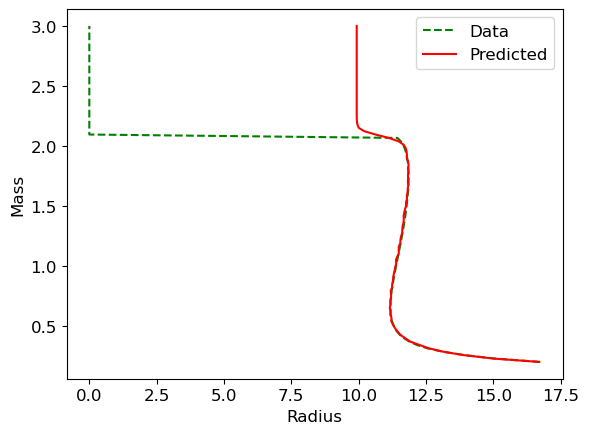

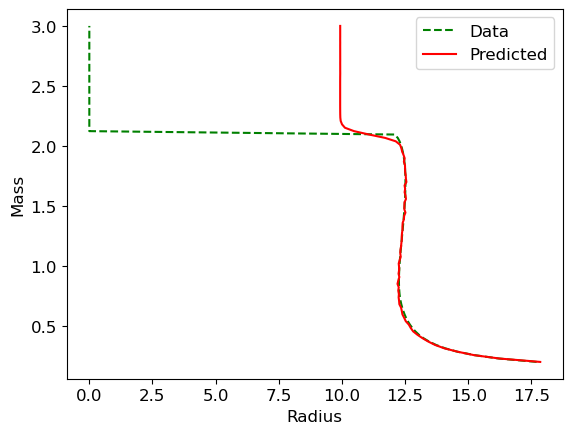

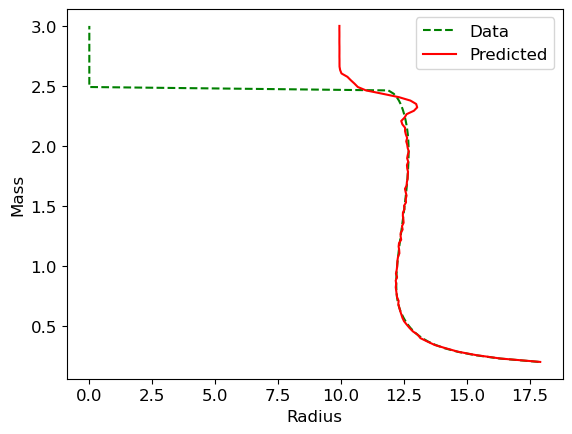

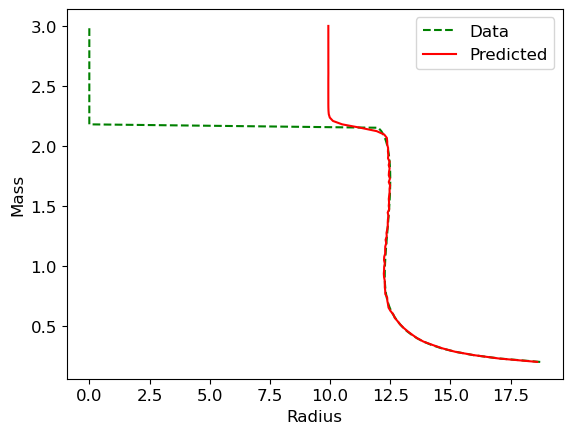

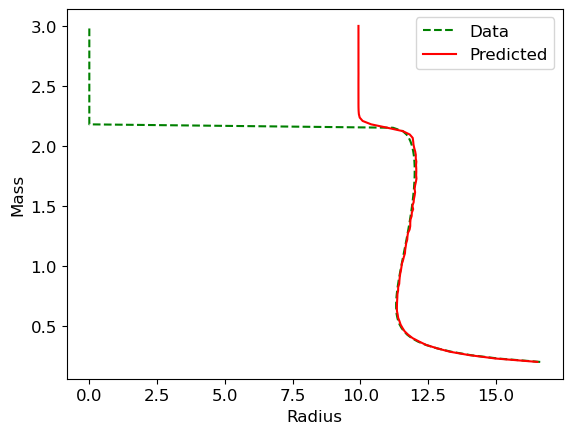

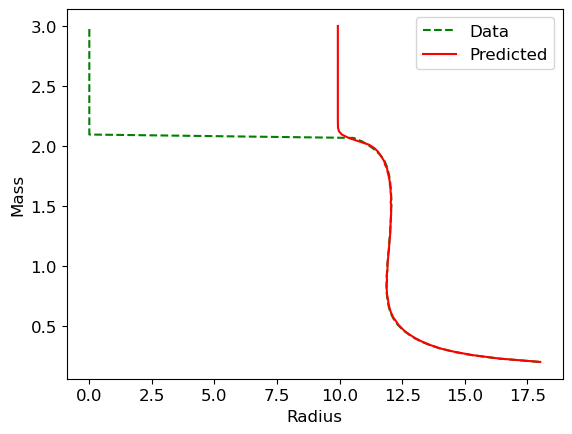

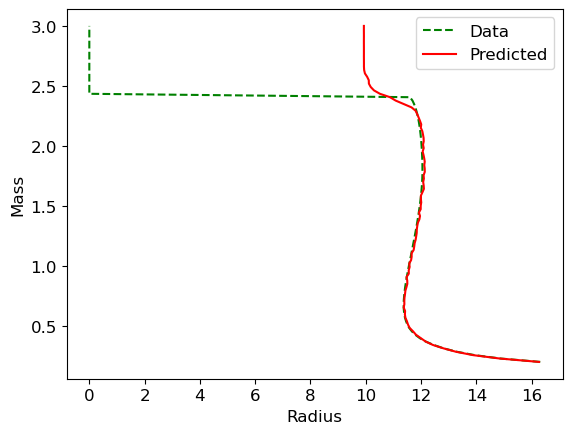

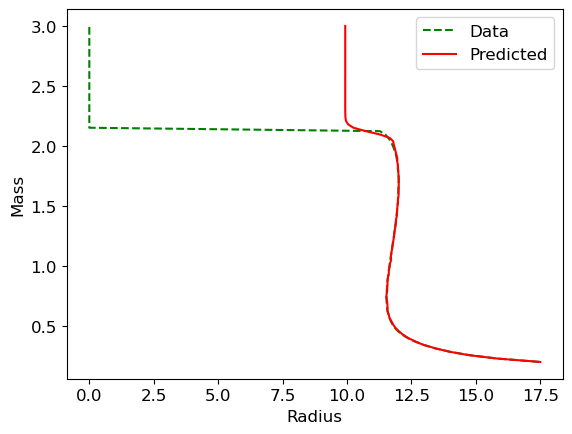

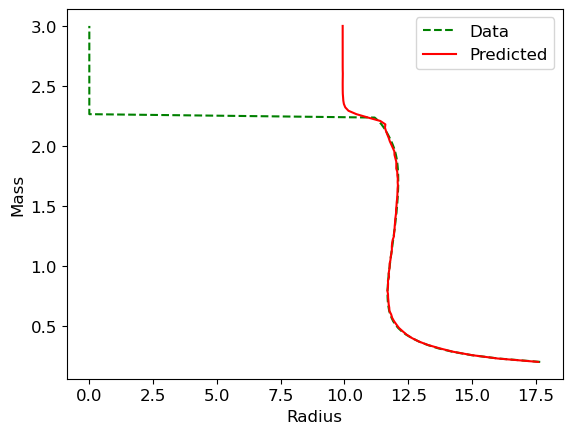

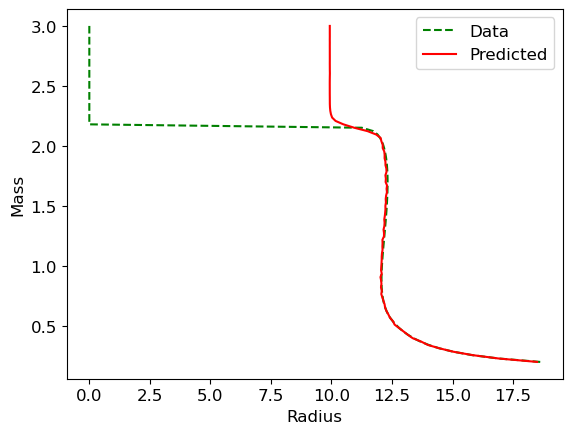

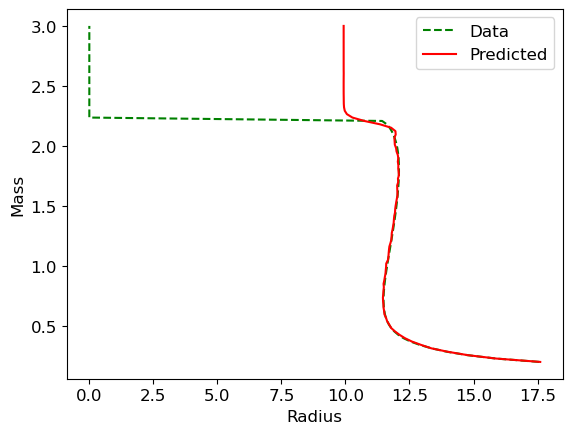

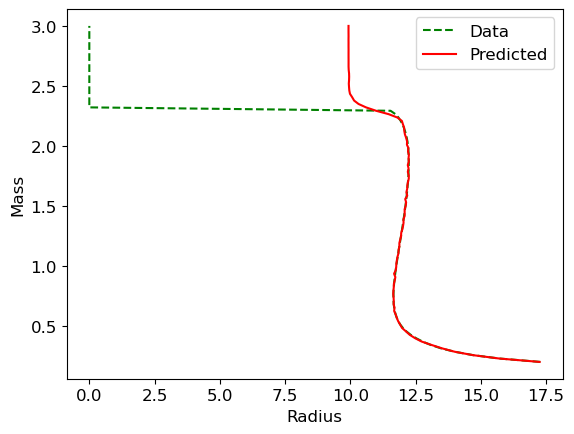

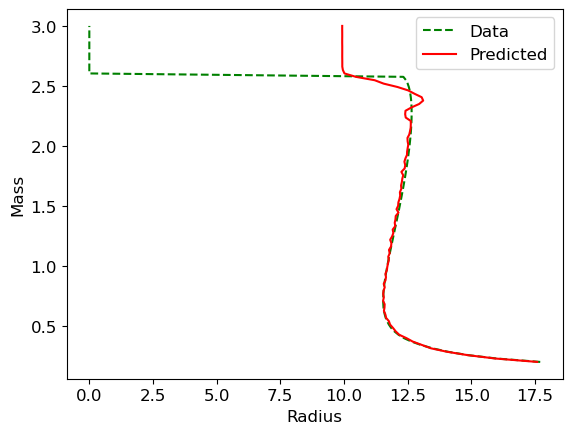

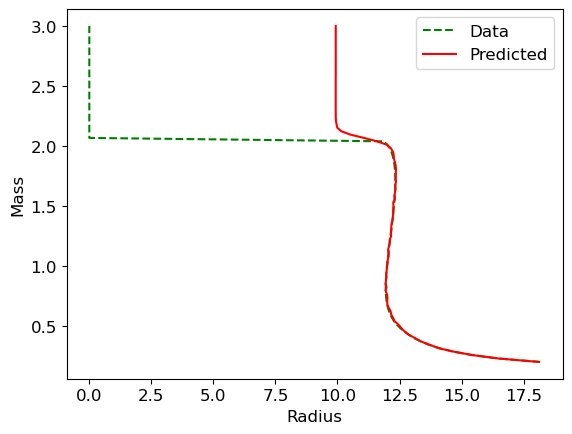

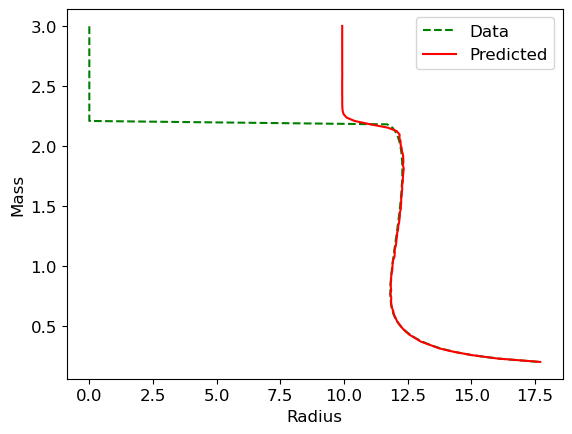

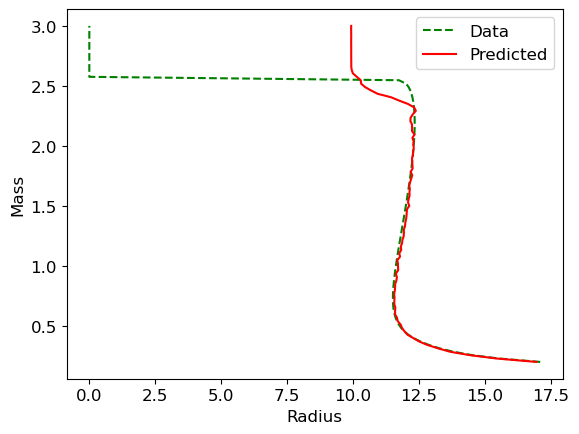

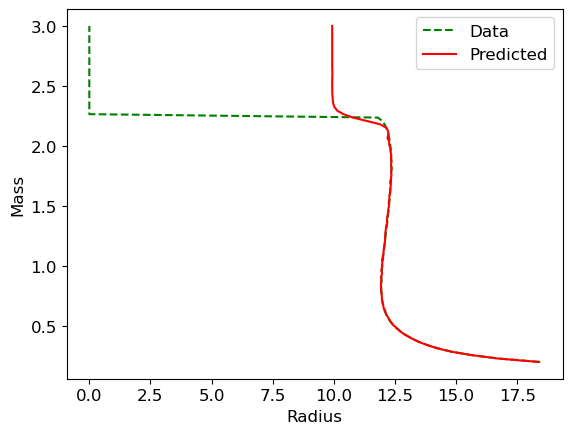

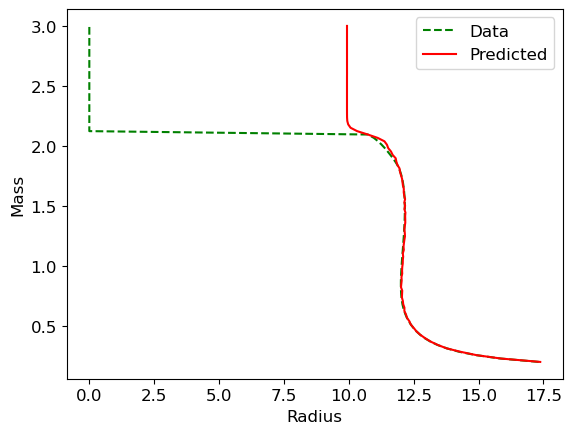

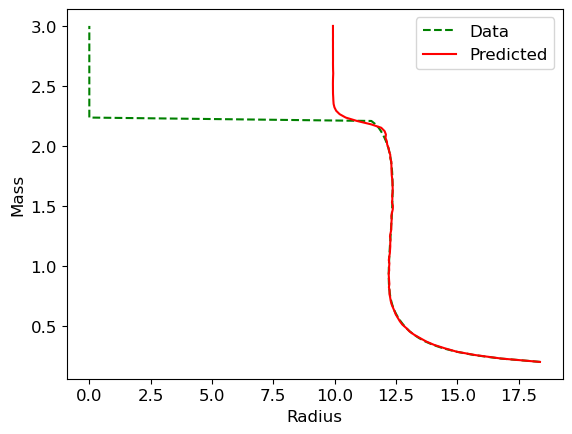

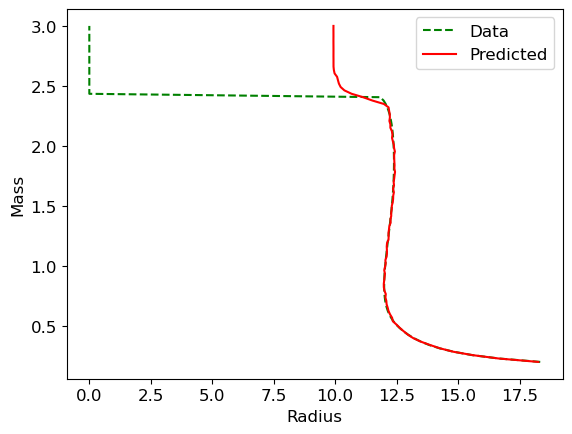

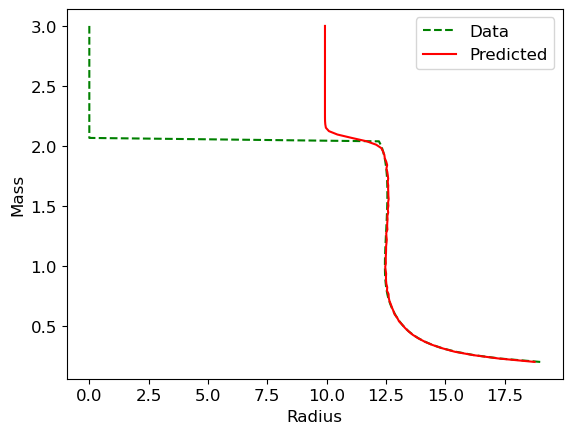

In [11]:
# Assume y_pr contains the normalized predictions and y_vl is the validation data
y_pr = best_model.predict(x_vl)

nz_pr = y_pr != 0
nz_dt = y_vl != 0

# Initialize arrays to store denormalized values
Y_pr = np.copy(y_pr)
Y_vl = np.copy(y_vl)

Y_pr[nz_pr] = scaler_Y.inverse_transform(y_pr[nz_pr].reshape(-1, 1)).flatten()
Y_vl[nz_dt] = scaler_Y.inverse_transform(y_vl[nz_dt].reshape(-1, 1)).flatten()

# Plot the results
m = np.linspace(0.2, 3.0, 100)
for i in range(22):
    plt.plot(Y_vl[i], m, label='Data', color='green', linestyle='--')
    plt.plot(Y_pr[i], m, label='Predicted', color='red')
    plt.xlabel("Radius")
    plt.ylabel("Mass")
    plt.legend()
    plt.show()
